# Baseline model

- Create a simple baseline model to compare future model performance against
- Use an 'out-of-the-box' (no tuning) LightGBM classifier to predict the likelihood of a goal in the next event given only the current event data (i.e. no time window)
- ROCAUC is main metric
- Also explore feature importance

## Set-up

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import shap
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
os.chdir('..')

In [3]:
pd.options.display.max_columns = None

## Process data for LightGBM

In [4]:
train = pd.read_parquet('data/processed/train.parquet')
print(train.shape)
train.head()

(749640, 13)


,id_odsp,sort_order,time,text,event_type,event_team,opponent,is_goal,assist_method,fast_break,season,country,event_team_was_home
0,UFot0hit/,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Hamburg SV,Borussia Dortmund,0,Pass,0,2012,germany,0
1,UFot0hit/,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
2,UFot0hit/,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
3,UFot0hit/,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
4,UFot0hit/,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,Hamburg SV,Borussia Dortmund,0,None,0,2012,germany,0


In [5]:
dev = pd.read_parquet('data/processed/dev.parquet')
dev.shape

(92689, 13)

In [6]:
train['set'] = 'train'
dev['set'] = 'dev'
combined = train.append(dev)

In [7]:
combined.head()

,id_odsp,sort_order,time,text,event_type,event_team,opponent,is_goal,assist_method,fast_break,season,country,event_team_was_home,set
0,UFot0hit/,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Hamburg SV,Borussia Dortmund,0,Pass,0,2012,germany,0,train
1,UFot0hit/,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1,train
2,UFot0hit/,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1,train
3,UFot0hit/,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1,train
4,UFot0hit/,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,Hamburg SV,Borussia Dortmund,0,None,0,2012,germany,0,train


In [8]:
def process_data_for_lightgbm(df):
    df = df.copy()
    
    # OHE
    df = pd.get_dummies(df, columns=['event_type', 'assist_method', 'season', 'country'])
    
    # Sort by event order
    df.sort_values(['id_odsp', 'sort_order'], inplace=True)
    
    # Create target
    df['next_event_is_goal'] = df.groupby('id_odsp')['is_goal'].shift(-1)
    
    # Drop redundant columns
    df.drop(columns=['sort_order', 'text', 'event_team', 'opponent', 'is_goal'], inplace=True)
    
    # Drop entries with null target due to -1 shift
    df.dropna(subset=['next_event_is_goal'], axis=0, inplace=True)
    
    return df

In [9]:
combined_processed = process_data_for_lightgbm(combined)

In [10]:
combined_processed.head()

,id_odsp,time,fast_break,event_team_was_home,set,event_type_Attempt,event_type_Corner,event_type_Foul,event_type_Free kick won,event_type_Hand ball,event_type_Offside,event_type_Penalty conceded,event_type_Red card,event_type_Second yellow card,event_type_Substitution,event_type_Yellow card,assist_method_Cross,assist_method_Headed pass,assist_method_None,assist_method_Pass,assist_method_Through ball,season_2012,season_2013,season_2014,season_2015,season_2016,country_england,country_france,country_germany,country_italy,country_spain,next_event_is_goal
516547,004f4ING/,1,0,0,train,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0.0
516548,004f4ING/,1,0,1,train,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0.0
516549,004f4ING/,5,0,1,train,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0.0
516550,004f4ING/,5,0,0,train,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0.0
516551,004f4ING/,6,0,1,train,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0


In [11]:
train_processed = combined_processed.copy()[combined_processed['set'] == 'train'].drop(columns=['set'])
X_train = train_processed.copy().drop(columns=['id_odsp', 'next_event_is_goal'])
y_train = train_processed['next_event_is_goal']

dev_processed = combined_processed.copy()[combined_processed['set'] == 'dev'].drop(columns=['set'])
X_dev = dev_processed.copy().drop(columns=['id_odsp', 'next_event_is_goal'])
y_dev = dev_processed['next_event_is_goal']

## Train baseline model

In [12]:
X_train.head()

,time,fast_break,event_team_was_home,event_type_Attempt,event_type_Corner,event_type_Foul,event_type_Free kick won,event_type_Hand ball,event_type_Offside,event_type_Penalty conceded,event_type_Red card,event_type_Second yellow card,event_type_Substitution,event_type_Yellow card,assist_method_Cross,assist_method_Headed pass,assist_method_None,assist_method_Pass,assist_method_Through ball,season_2012,season_2013,season_2014,season_2015,season_2016,country_england,country_france,country_germany,country_italy,country_spain
516547,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
516548,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
516549,5,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
516550,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
516551,6,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [13]:
baseline = lightgbm.LGBMClassifier()

In [14]:
X_train = train_processed.copy().drop(columns=['id_odsp', 'next_event_is_goal'])
y_train = train_processed['next_event_is_goal']

In [15]:
baseline.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Evaluate model

In [16]:
predictions = baseline.predict_proba(X_train)[:,1]

In [17]:
# Training ROCAUC
roc_auc_score(y_train, predictions)

0.6818084086736118

In [18]:
# All-zero accuracy
accuracy_score(y_train, np.zeros(y_train.shape))

0.9741906112657807

In [19]:
# Model training accuracy
accuracy_score(y_train, baseline.predict(X_train))

0.974252568884076

In [20]:
predictions = baseline.predict_proba(X_dev)[:,1]

In [21]:
# Training ROCAUC
roc_auc_score(y_dev, predictions)

0.6640326300257362

In [22]:
# All-zero accuracy
accuracy_score(y_dev, np.zeros(y_dev.shape))

0.9735480286308817

In [23]:
# Model training accuracy
accuracy_score(y_dev, baseline.predict(X_dev))

0.9734608722178039

## Feature importance

In [24]:
explainer = shap.TreeExplainer(baseline)

In [25]:
%%time
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


CPU times: user 11min 30s, sys: 1.13 s, total: 11min 31s
Wall time: 1min 29s


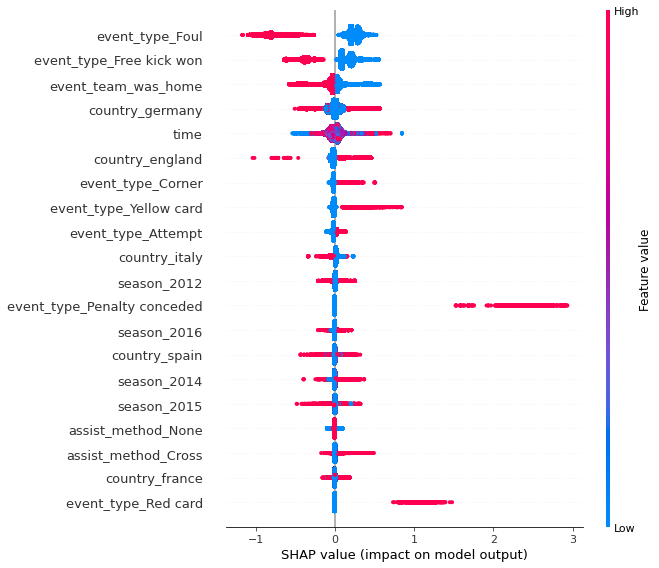

In [35]:
shap.summary_plot(shap_values[1], X_train, plot_type='dot', max_display=None)

- Good that model identifies penalties and red cards as strong predictors of a goal
- Surprising that foals lead to strong negative influence on prediction. One hypothesis is that most foals are not neessarily stopping goal scoring opportunities and if they are away from the box the immediate passage of play may not lead to a goal
- Some ordering of league country. Surprising that Spain is below Italy.
- Would hope that NLP model is able to identify foal and set piece features.

## Key conclusions

- Training ROCAUC: 0.6818084086736118
- Dev ROCAUC: 0.6640326300257362
- Model generalises pretty well